In [1]:
import pickle
import numpy as np
import readLHE
from readLHE import Particle, Event
import invariants
import matplotlib.pyplot as plt
import scipy.spatial
from numpy import inf
import pickle
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

def get_kl_js(data_p, data_q):
    pdfp = scipy.stats.rv_histogram(np.histogram(data_p, bins=100))
    pdfq = scipy.stats.rv_histogram(np.histogram(data_q, bins=100))
    p = pdfp.pdf(np.linspace(min(data_p), max(data_p), 100))
    q = pdfq.pdf(np.linspace(min(data_q), max(data_q), 100))
    kl_div = scipy.special.kl_div(p,q)
    kl_div[kl_div == inf] = 0
    js_div = scipy.spatial.distance.jensenshannon(p, q)**2
    return np.sum(kl_div), js_div

def get_event(s, t, y, beamE=6500, m=173.):
    E3_cm = np.sqrt(s)/2
    x_2 = np.sqrt(s)/2/beamE*np.exp(-y)
    x_1 = x_2*np.exp(2*y)
    cos_theta_cm = 1 + 2*t/s
    sin_theta_cm = np.sqrt(1-cos_theta_cm**2)
    pz_cm = np.sqrt(s)/2*cos_theta_cm
    pz = pz_cm*np.cosh(y)+E3_cm*np.sinh(y)
    E3 = E3_cm*np.cosh(y)+pz_cm*np.sinh(y)
    pt = np.sqrt(E3**2-(pz**2 + m**2))
    E1 = x_1*beamE
    E2 = x_2*beamE
    d_p1 = {'e': E1, 'px': 0., 'py': 0., 'pz': E1}
    d_p2 = {'e': E2, 'px': 0., 'py': 0., 'pz': -E2}
    d_p3 = {'e': E3, 'px': pt, 'py': 0., 'pz': pz}
    d_p4 = {'e': E1+E2-E3, 'px': -pt, 'py': 0., 'pz': E1-E2-pz}
    p1 = Particle(d_p1)
    p2 = Particle(d_p2)
    p3 = Particle(d_p3)
    p4 = Particle(d_p4)
    ev = Event([p1,p2,p3,p4])
    return ev

**p p -> t tbar**

In [46]:
with open('dcgan-opt/outputs/preprocess/s_scaler.pickle', 'rb') as s_scaler, open('dcgan-opt/outputs/preprocess/t_scaler.pickle', 'rb') as t_scaler, open('dcgan-opt/outputs/preprocess/minmax_scaler.pickle', 'rb') as minmax_scaler:
    scal1 = pickle.load(s_scaler)
    scal2 = pickle.load(t_scaler)
    scal3 = pickle.load(minmax_scaler)

pred = np.loadtxt('dcgan-opt/outputs/pred.txt')
pred = scal3.inverse_transform(pred)
pred[:,0] = scal1.inverse_transform(pred[:,0].reshape(-1,1)).flatten()
pred[:,1] = scal2.inverse_transform(pred[:,1].reshape(-1,1)).flatten()

file = '../samples/ppttbar_10k_events.lhe'
evs = readLHE.readEvent(file)
init = readLHE.readInit(file)
invar = np.zeros((readLHE.NEvents(file),3))
i = 0
for ev in evs:
    invar[i,0] = invariants.GetEnergySquared(ev)
    invar[i,1] = invariants.GetMandelT(ev)
    invar[i,2] = invariants.GetRapidity(init, ev)
    i += 1

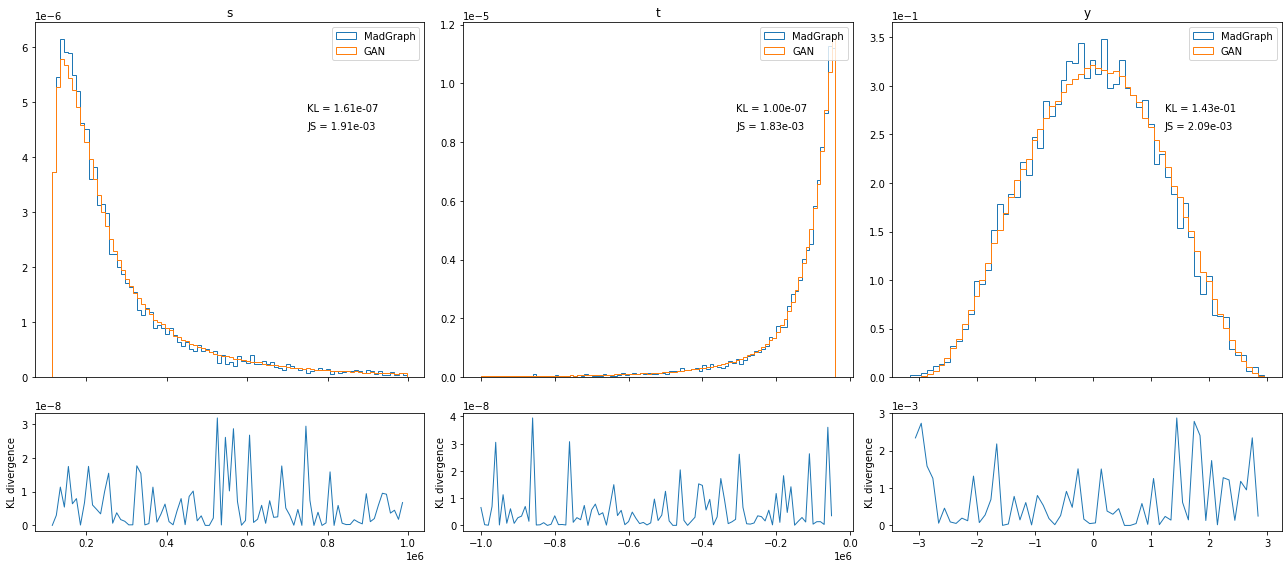

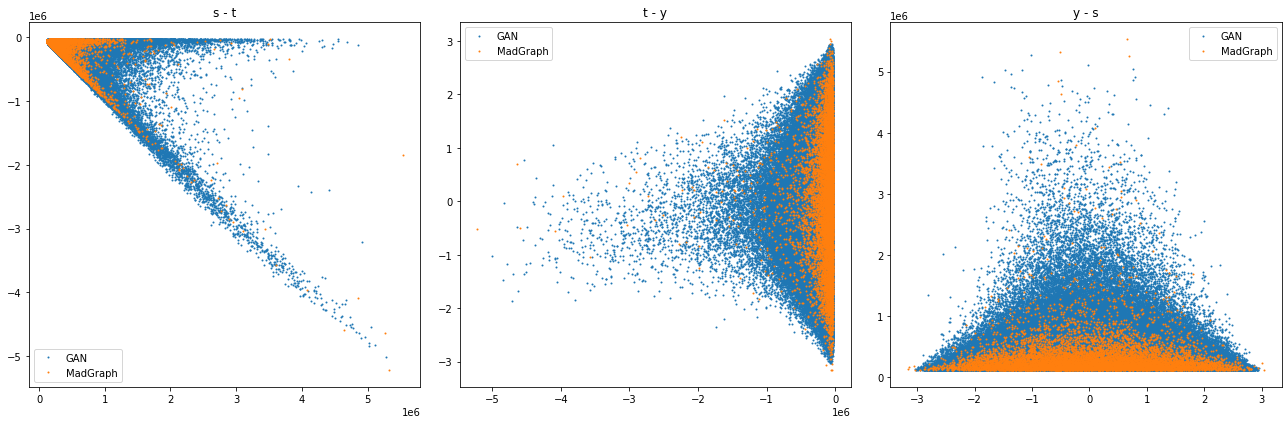

In [47]:
bins = [np.arange(min(invar[:,0]), 1e6, 1e4), np.arange(-1e6, max(invar[:,1]), 1e4), np.arange(min(invar[:,2]), max(invar[:,2]), 0.1)]
labels = ['s', 't', 'y']
fig, ax = plt.subplots(2,3, figsize=(18,8), gridspec_kw={'height_ratios': [3,1]}, sharex='col')

for i in range(3):
    valt, bs, _ = ax[0,i].hist(invar[:,i], bins=bins[i], histtype='step', label='MadGraph', density=True)
    valg, bs, _ = ax[0,i].hist(pred[:,i], bins=bins[i], histtype='step', label='GAN', density=True)
    ax[0,i].set_title(labels[i])
    ax[0,i].legend(loc='best')
    ax[0,i].annotate('KL = {:.2e}'.format(np.sum(get_kl_js(invar[:,i], pred[:,i])[0])), xy=(0.70, 0.75), xycoords='axes fraction')
    ax[0,i].annotate('JS = {:.2e}'.format(get_kl_js(invar[:,i], pred[:,i])[1]), xy=(0.70, 0.70), xycoords='axes fraction')
    ax[0,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    ax[1,i].plot(bs[:-1], scipy.special.kl_div(valt,valg), linewidth='1')
    ax[1,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    ax[1,i].set_ylabel('KL divergence')
fig.tight_layout()
fig.subplots_adjust(hspace=0.15,wspace=0.1)

fig2, ax2 = plt.subplots(1,3, figsize=(18,6))
for i in range(3):
    ax2[i].plot(pred[:,i], pred[:,(i+1)%3], 'o', markersize=1, label='GAN')
    ax2[i].plot(invar[:,i%3], invar[:,(i+1)%3],'o', markersize=1, label='MadGraph')
    ax2[i].set_title(labels[i%3]+' - '+labels[(i+1)%3])
    ax2[i].legend(loc='best')
    ax2[i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
fig2.tight_layout()
fig2.subplots_adjust(hspace=0.15,wspace=0.1)

**p p -> t tbar - pt > 250GeV, -2.5 < y < 2.5**

In [57]:
with open('dcgan-cuts/outputs/preprocess/s_scaler.pickle', 'rb') as s_scaler, open('dcgan-cuts/outputs/preprocess/t_scaler.pickle', 'rb') as t_scaler, open('dcgan-cuts/outputs/preprocess/minmax_scaler.pickle', 'rb') as minmax_scaler:
    scal1 = pickle.load(s_scaler)
    scal2 = pickle.load(t_scaler)
    scal3 = pickle.load(minmax_scaler)

pred = np.loadtxt('dcgan-cuts/outputs/pred.txt')
pred = scal3.inverse_transform(pred)
pred[:,0] = scal1.inverse_transform(pred[:,0].reshape(-1,1)).flatten()
pred[:,1] = scal2.inverse_transform(pred[:,1].reshape(-1,1)).flatten()

file = '../samples/ppttbar_10k_events_cuts.lhe'
evs = readLHE.readEvent(file)
init = readLHE.readInit(file)
invar = np.zeros((readLHE.NEvents(file),3))
i = 0
for ev in evs:
    invar[i,0] = invariants.GetEnergySquared(ev)
    invar[i,1] = invariants.GetMandelT(ev)
    invar[i,2] = invariants.GetRapidity(init, ev)
    i += 1

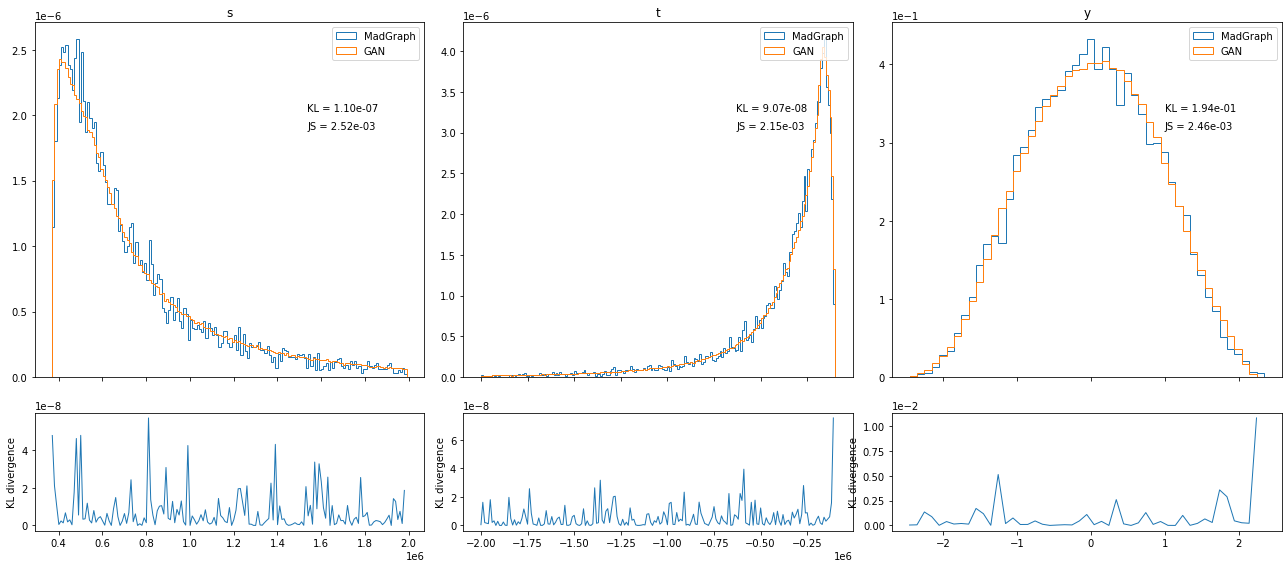

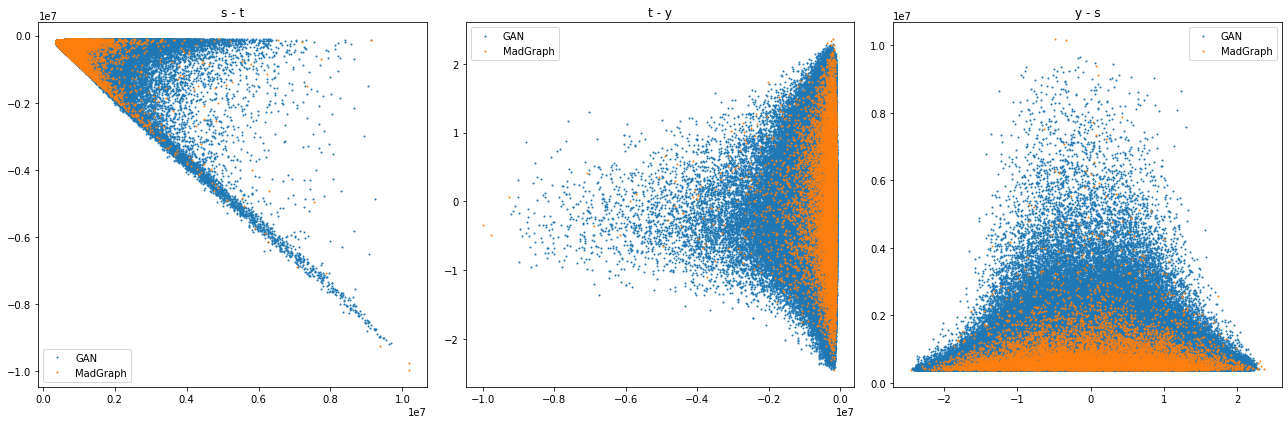

In [58]:
bins = [np.arange(min(invar[:,0]), 2e6, 1e4), np.arange(-2e6, max(invar[:,1]), 1e4), np.arange(min(invar[:,2]), max(invar[:,2]), 0.1)]
labels = ['s', 't', 'y']
fig, ax = plt.subplots(2,3, figsize=(18,8), gridspec_kw={'height_ratios': [3,1]}, sharex='col')

for i in range(3):
    valt, bs, _ = ax[0,i].hist(invar[:,i], bins=bins[i], histtype='step', label='MadGraph', density=True)
    valg, bs, _ = ax[0,i].hist(pred[:,i], bins=bins[i], histtype='step', label='GAN', density=True)
    ax[0,i].set_title(labels[i])
    ax[0,i].legend(loc='best')
    ax[0,i].annotate('KL = {:.2e}'.format(np.sum(get_kl_js(invar[:,i], pred[:,i])[0])), xy=(0.70, 0.75), xycoords='axes fraction')
    ax[0,i].annotate('JS = {:.2e}'.format(get_kl_js(invar[:,i], pred[:,i])[1]), xy=(0.70, 0.70), xycoords='axes fraction')
    ax[0,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    ax[1,i].plot(bs[:-1], scipy.special.kl_div(valt,valg), linewidth='1')
    ax[1,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    ax[1,i].set_ylabel('KL divergence')
fig.tight_layout()
fig.subplots_adjust(hspace=0.15,wspace=0.1)

fig2, ax2 = plt.subplots(1,3, figsize=(18,6))
for i in range(3):
    ax2[i].plot(pred[:,i], pred[:,(i+1)%3], 'o', markersize=1, label='GAN')
    ax2[i].plot(invar[:,i%3], invar[:,(i+1)%3],'o', markersize=1, label='MadGraph')
    ax2[i].set_title(labels[i%3]+' - '+labels[(i+1)%3])
    ax2[i].legend(loc='best')
    ax2[i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
fig2.tight_layout()
fig2.subplots_adjust(hspace=0.15,wspace=0.1)

In [59]:
pt = []
for ev in map(get_event, pred[:,0], pred[:,1], pred[:,2]):
    pt.append(ev.particles[2].p[1])

/Users/luigifavaro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/Users/luigifavaro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


(200, 252.0)

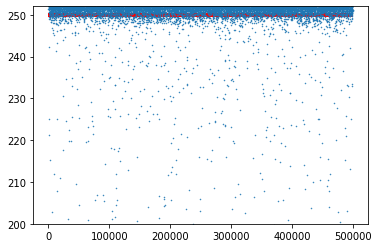

In [65]:
plt.plot(pt, 'o', markersize=0.5)
plt.hlines(250, 0, 500000, linewidth=4, color='red')
plt.ylim(200, 252.)

**g g -> Z Z**

In [48]:
with open('dcgan-ggzz/outputs/preprocess/s_scaler.pickle', 'rb') as s_scaler, open('dcgan-ggzz/outputs/preprocess/t_scaler.pickle', 'rb') as t_scaler, open('dcgan-ggzz/outputs/preprocess/minmax_scaler.pickle', 'rb') as minmax_scaler:
    scal1 = pickle.load(s_scaler)
    scal2 = pickle.load(t_scaler)
    scal3 = pickle.load(minmax_scaler)

pred = np.loadtxt('dcgan-ggzz/outputs/pred.txt')
pred = scal3.inverse_transform(pred)
pred[:,0] = scal1.inverse_transform(pred[:,0].reshape(-1,1)).flatten()
pred[:,1] = scal2.inverse_transform(pred[:,1].reshape(-1,1)).flatten()

file = '../samples/ggzz_1loop_10k_events.lhe'
evs = readLHE.readEvent(file)
init = readLHE.readInit(file)
invar = np.zeros((readLHE.NEvents(file),3))
i = 0
for ev in evs:
    invar[i,0] = invariants.GetEnergySquared(ev)
    invar[i,1] = invariants.GetMandelT(ev)
    invar[i,2] = invariants.GetRapidity(init, ev)
    i += 1

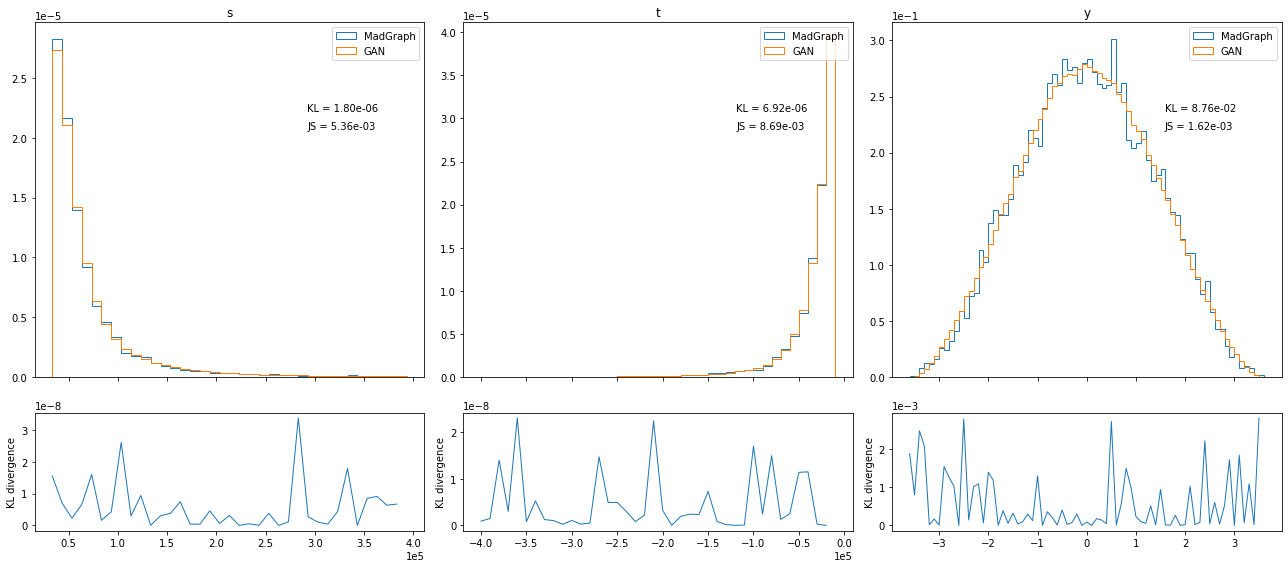

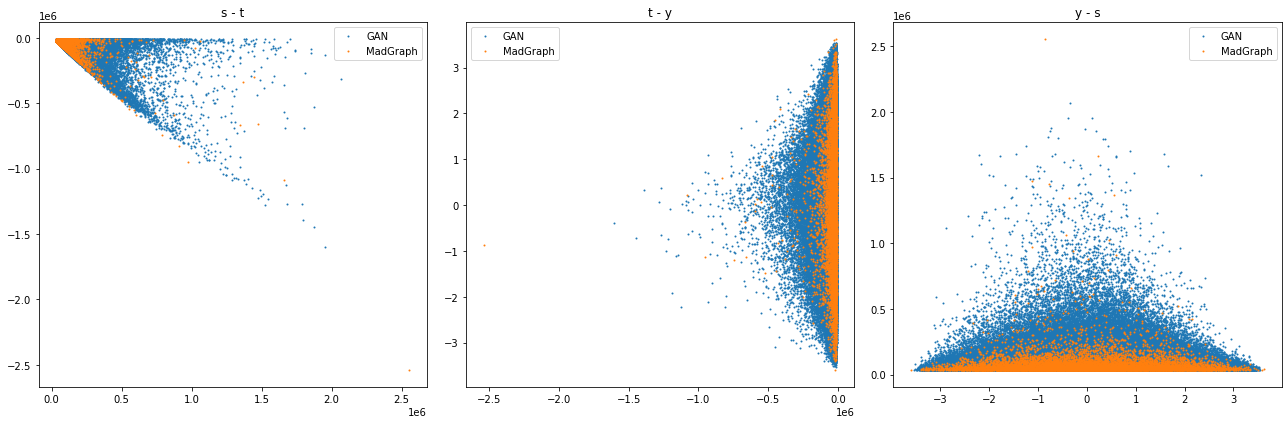

In [49]:
bins = [np.arange(min(invar[:,0]), 0.4e6, 1e4), np.arange(-0.4e6, max(invar[:,1]), 1e4), np.arange(min(invar[:,2]), max(invar[:,2]), 0.1)]
labels = ['s', 't', 'y']
fig, ax = plt.subplots(2,3, figsize=(18,8), gridspec_kw={'height_ratios': [3,1]}, sharex='col')

for i in range(3):
    valt, bs, _ = ax[0,i].hist(invar[:,i], bins=bins[i], histtype='step', label='MadGraph', density=True)
    valg, bs, _ = ax[0,i].hist(pred[:,i], bins=bins[i], histtype='step', label='GAN', density=True)
    ax[0,i].set_title(labels[i])
    ax[0,i].legend(loc='best')
    ax[0,i].annotate('KL = {:.2e}'.format(np.sum(get_kl_js(invar[:,i], pred[:,i])[0])), xy=(0.70, 0.75), xycoords='axes fraction')
    ax[0,i].annotate('JS = {:.2e}'.format(get_kl_js(invar[:,i], pred[:,i])[1]), xy=(0.70, 0.70), xycoords='axes fraction')
    ax[0,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    ax[1,i].plot(bs[:-1], scipy.special.kl_div(valt,valg), linewidth='1')
    ax[1,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    ax[1,i].set_ylabel('KL divergence')
fig.tight_layout()
fig.subplots_adjust(hspace=0.15,wspace=0.1)

fig2, ax2 = plt.subplots(1,3, figsize=(18,6))
for i in range(3):
    ax2[i].plot(pred[:,i], pred[:,(i+1)%3], 'o', markersize=1, label='GAN')
    ax2[i].plot(invar[:,i%3], invar[:,(i+1)%3],'o', markersize=1, label='MadGraph')
    ax2[i].set_title(labels[i%3]+' - '+labels[(i+1)%3])
    ax2[i].legend(loc='best')
    ax2[i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
fig2.tight_layout()
fig2.subplots_adjust(hspace=0.15,wspace=0.1)

**g g -> H H**

In [50]:
with open('dcgan-gghh/outputs/preprocess/s_scaler.pickle', 'rb') as s_scaler, open('dcgan-gghh/outputs/preprocess/t_scaler.pickle', 'rb') as t_scaler, open('dcgan-gghh/outputs/preprocess/minmax_scaler.pickle', 'rb') as minmax_scaler:
    scal1 = pickle.load(s_scaler)
    scal2 = pickle.load(t_scaler)
    scal3 = pickle.load(minmax_scaler)

pred = np.loadtxt('dcgan-gghh/outputs/pred.txt')
pred = scal3.inverse_transform(pred)
pred[:,0] = scal1.inverse_transform(pred[:,0].reshape(-1,1)).flatten()
pred[:,1] = scal2.inverse_transform(pred[:,1].reshape(-1,1)).flatten()

file = '../samples/gghh_1loop_10k_events.lhe'
evs = readLHE.readEvent(file)
init = readLHE.readInit(file)
invar = np.zeros((readLHE.NEvents(file),3))
i = 0
for ev in evs:
    invar[i,0] = invariants.GetEnergySquared(ev)
    invar[i,1] = invariants.GetMandelT(ev)
    invar[i,2] = invariants.GetRapidity(init, ev)
    i += 1

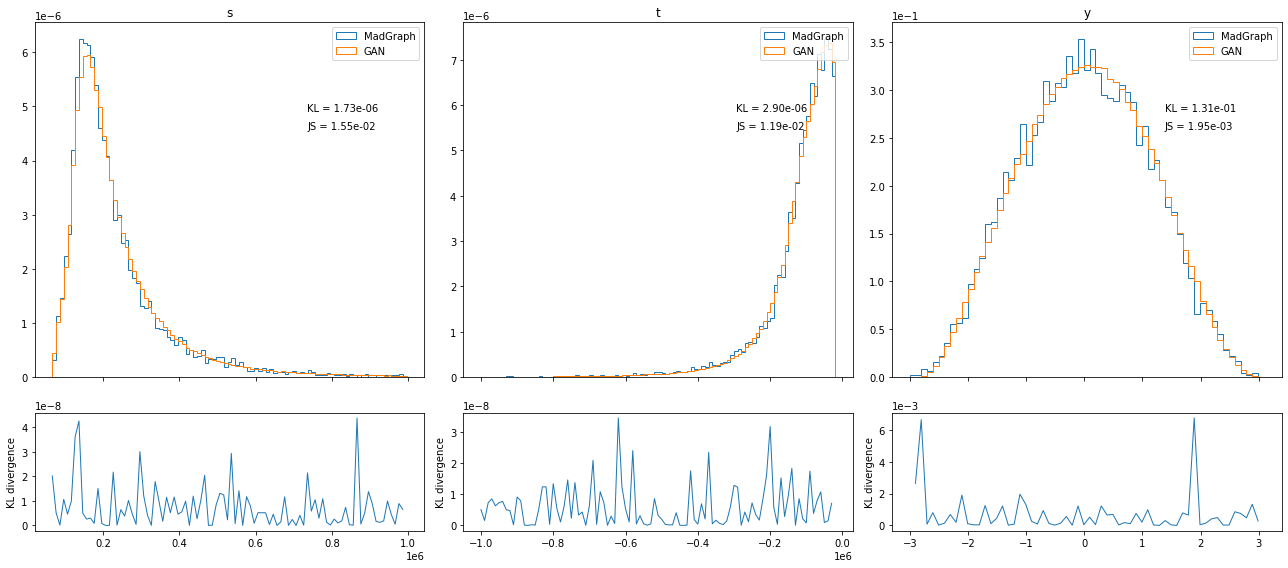

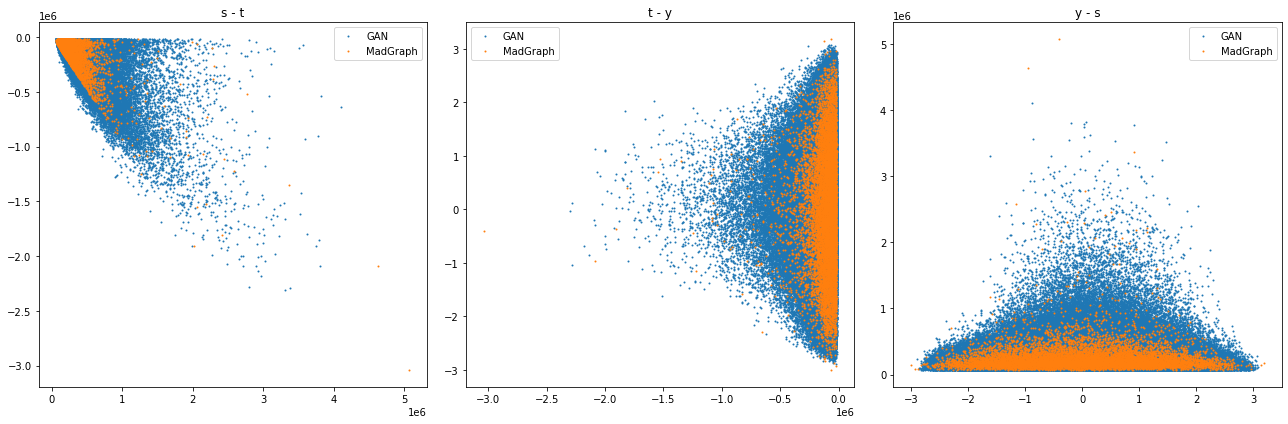

In [51]:
bins = [np.arange(min(invar[:,0]), 1e6, 1e4), np.arange(-1e6, max(invar[:,1]), 1e4), np.arange(min(invar[:,2]), max(invar[:,2]), 0.1)]
labels = ['s', 't', 'y']
fig, ax = plt.subplots(2,3, figsize=(18,8), gridspec_kw={'height_ratios': [3,1]}, sharex='col')

for i in range(3):
    valt, bs, _ = ax[0,i].hist(invar[:,i], bins=bins[i], histtype='step', label='MadGraph', density=True)
    valg, bs, _ = ax[0,i].hist(pred[:,i], bins=bins[i], histtype='step', label='GAN', density=True)
    ax[0,i].set_title(labels[i])
    ax[0,i].annotate('KL = {:.2e}'.format(np.sum(get_kl_js(invar[:,i], pred[:,i])[0])), xy=(0.70, 0.75), xycoords='axes fraction')
    ax[0,i].annotate('JS = {:.2e}'.format(get_kl_js(invar[:,i], pred[:,i])[1]), xy=(0.70, 0.70), xycoords='axes fraction')
    ax[0,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    ax[1,i].plot(bs[:-1], scipy.special.kl_div(valt,valg), linewidth='1')
    ax[1,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    ax[1,i].set_ylabel('KL divergence')
    ax[0,i].legend(loc='best')
fig.tight_layout()
fig.subplots_adjust(hspace=0.15,wspace=0.1)

fig2, ax2 = plt.subplots(1,3, figsize=(18,6))
for i in range(3):
    ax2[i].plot(pred[:,i], pred[:,(i+1)%3], 'o', markersize=1, label='GAN')
    ax2[i].plot(invar[:,i%3], invar[:,(i+1)%3],'o', markersize=1, label='MadGraph')
    ax2[i].set_title(labels[i%3]+' - '+labels[(i+1)%3])
    ax2[i].legend(loc='best')
    ax2[i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
fig2.tight_layout()
fig2.subplots_adjust(hspace=0.15,wspace=0.1)

In [2]:
with open('dcgan-gghh_50k/outputs/preprocess/s_scaler.pickle', 'rb') as s_scaler, open('dcgan-gghh_50k/outputs/preprocess/t_scaler.pickle', 'rb') as t_scaler, open('dcgan-gghh_50k/outputs/preprocess/minmax_scaler.pickle', 'rb') as minmax_scaler:
    scal1 = pickle.load(s_scaler)
    scal2 = pickle.load(t_scaler)
    scal3 = pickle.load(minmax_scaler)

pred = np.loadtxt('dcgan-gghh_50k/outputs/pred.txt')
pred = scal3.inverse_transform(pred)
pred[:,0] = scal1.inverse_transform(pred[:,0].reshape(-1,1)).flatten()
pred[:,1] = scal2.inverse_transform(pred[:,1].reshape(-1,1)).flatten()

file = '../samples/gghh_1loop_10k_events.lhe'
evs = readLHE.readEvent(file)
init = readLHE.readInit(file)
invar = np.zeros((readLHE.NEvents(file),3))
i = 0
for ev in evs:
    invar[i,0] = invariants.GetEnergySquared(ev)
    invar[i,1] = invariants.GetMandelT(ev)
    invar[i,2] = invariants.GetRapidity(init, ev)
    i += 1

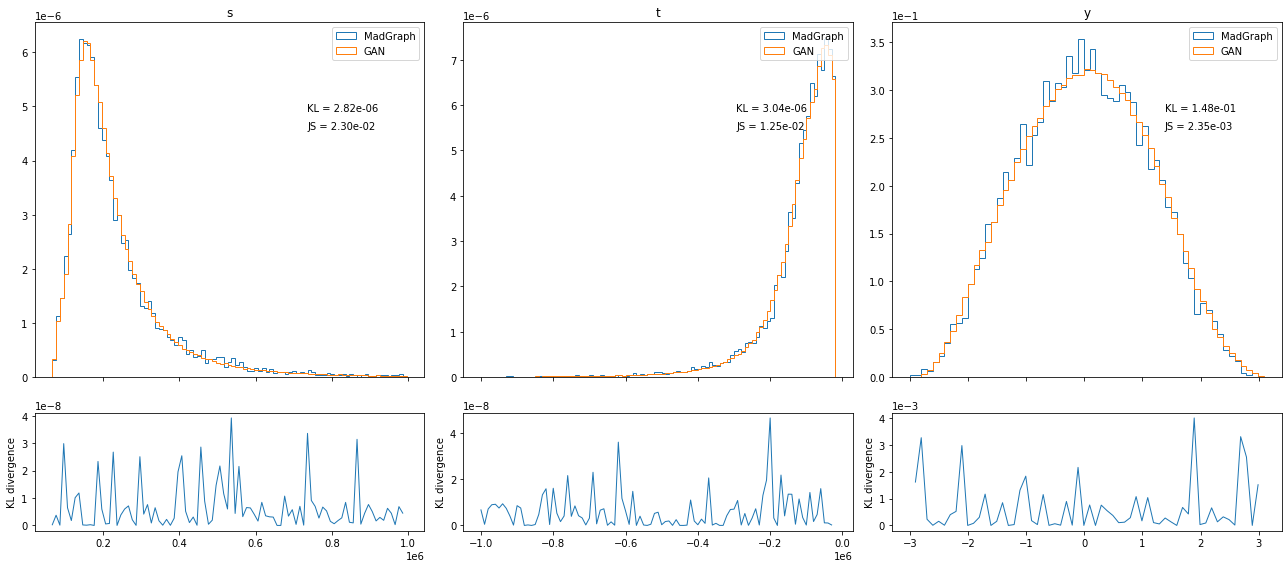

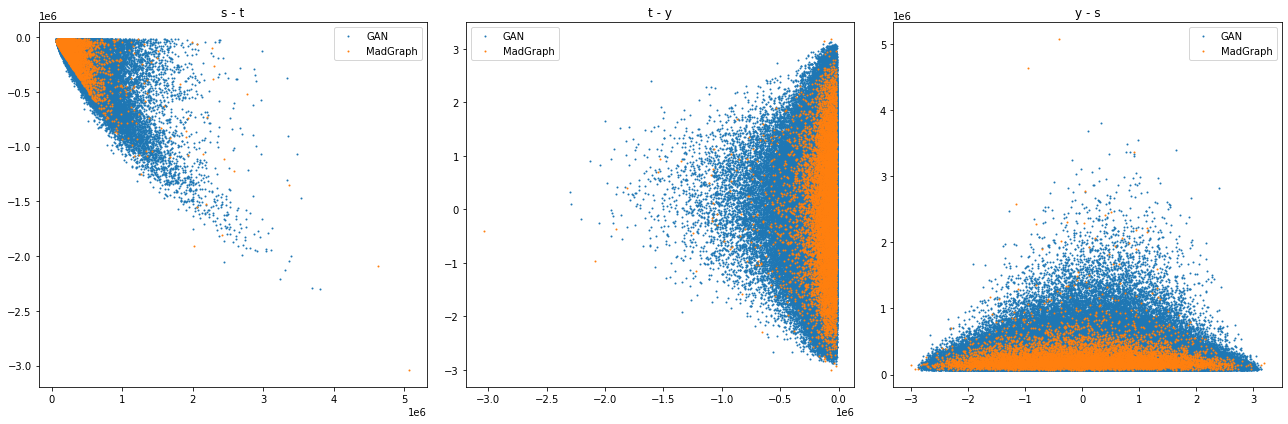

In [3]:
bins = [np.arange(min(invar[:,0]), 1e6, 1e4), np.arange(-1e6, max(invar[:,1]), 1e4), np.arange(min(invar[:,2]), max(invar[:,2]), 0.1)]
labels = ['s', 't', 'y']
fig, ax = plt.subplots(2,3, figsize=(18,8), gridspec_kw={'height_ratios': [3,1]}, sharex='col')

for i in range(3):
    valt, bs, _ = ax[0,i].hist(invar[:,i], bins=bins[i], histtype='step', label='MadGraph', density=True)
    valg, bs, _ = ax[0,i].hist(pred[:,i], bins=bins[i], histtype='step', label='GAN', density=True)
    ax[0,i].set_title(labels[i])
    ax[0,i].annotate('KL = {:.2e}'.format(np.sum(get_kl_js(invar[:,i], pred[:,i])[0])), xy=(0.70, 0.75), xycoords='axes fraction')
    ax[0,i].annotate('JS = {:.2e}'.format(get_kl_js(invar[:,i], pred[:,i])[1]), xy=(0.70, 0.70), xycoords='axes fraction')
    ax[0,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    ax[1,i].plot(bs[:-1], scipy.special.kl_div(valt,valg), linewidth='1')
    ax[1,i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    ax[1,i].set_ylabel('KL divergence')
    ax[0,i].legend(loc='best')
fig.tight_layout()
fig.subplots_adjust(hspace=0.15,wspace=0.1)

fig2, ax2 = plt.subplots(1,3, figsize=(18,6))
for i in range(3):
    ax2[i].plot(pred[:,i], pred[:,(i+1)%3], 'o', markersize=1, label='GAN')
    ax2[i].plot(invar[:,i%3], invar[:,(i+1)%3],'o', markersize=1, label='MadGraph')
    ax2[i].set_title(labels[i%3]+' - '+labels[(i+1)%3])
    ax2[i].legend(loc='best')
    ax2[i].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
fig2.tight_layout()
fig2.subplots_adjust(hspace=0.15,wspace=0.1)